In [1]:
#Modified from n1try's algorithm in OpenAI Gym
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
%matplotlib inline
import matplotlib.pyplot as plt
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import tensorflow as tf;

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    #anim.save('animation.gif', writer='imagemagick', fps=30)

def ortho_init(scale=1.0):
    def _ortho_init(shape, dtype, partition_info=None):
        #lasagne ortho init for tf
        shape = tuple(shape)
        if len(shape) == 2:
            flat_shape = shape
        elif len(shape) == 4: # assumes NHWC
            flat_shape = (np.prod(shape[:-1]), shape[-1])
        else:
            raise NotImplementedError
        a = np.random.normal(0.0, 1.0, flat_shape)
        u, _, v = np.linalg.svd(a, full_matrices=False)
        q = u if u.shape == flat_shape else v # pick the one with the correct shape
        q = q.reshape(shape)
        return (scale * q[:shape[0], :shape[1]]).astype(np.float32)
    return _ortho_init

def fc(x, scope, nh, act=tf.nn.relu, init_scale=1.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[1].value
        w = tf.get_variable("w", [nin, nh], initializer=ortho_init(init_scale))
        b = tf.get_variable("b", [nh], initializer=tf.constant_initializer(0.0))
        z = tf.matmul(x, w)+b
        h = act(z)
        return h

class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        self.cur_episode = 0;
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps
        self.session = tf.Session()
        # Init model
        self.model_state = tf.placeholder(dtype =tf.float32,shape=(None,4));
        self.q_target = tf.placeholder(dtype = tf.float32,shape=(None,2))
        self.layer1out = fc(x=self.model_state,scope='fc1',nh=24,act=tf.nn.tanh);
        self.layer2out = fc(x=self.layer1out,scope='fc2',nh=48,act=tf.nn.tanh);
        self.q_prediction = fc(x=self.layer2out,scope='fc3',nh=2,act=lambda x : x);
        self.loss = tf.reduce_mean((self.q_target-self.q_prediction)**2)
        self.train_step = tf.train.AdamOptimizer(learning_rate = self.alpha).minimize(self.loss)
        self.session.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.predict(state))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def predict(self,state):
        return self.session.run(self.q_prediction,feed_dict={self.model_state:state})

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.session.run(self.train_step,feed_dict={self.model_state:np.array(x_batch),self.q_target: np.array(y_batch)})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self,n_episodes=1000):
        scores = deque(maxlen=100)
        for e in range(self.cur_episode,self.cur_episode+n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e
    
    def displaySingleEpisode(self):
        frames = [] 
        done = False;
        state = self.preprocess_state(self.env.reset())
        while not done:
            action = self.choose_action(state, 1.0)
            next_state, reward, done, _ = self.env.step(action)
            frames.append(self.env.render(mode='rgb_array'))
        self.env.render(mode='rgb_array',close=True)
        display_frames_as_gif(frames)

Using TensorFlow backend.


[Episode 0] - Mean survival time over last 100 episodes was 14.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 15.38 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 39.44 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 64.7 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 104.22 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 118.54 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 102.96 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 113.47 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 118.38 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 144.18 ticks.
Did not solve after 999 episodes 😞



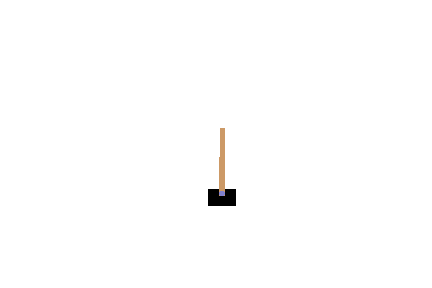
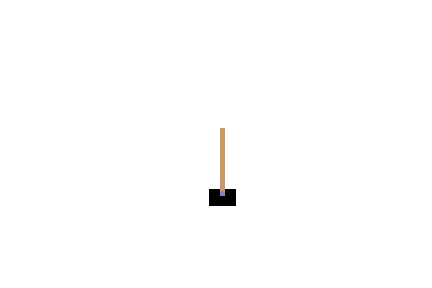
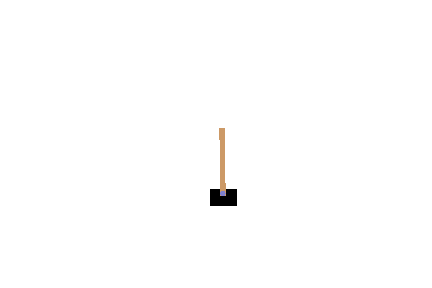
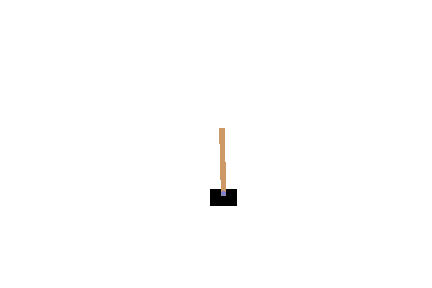
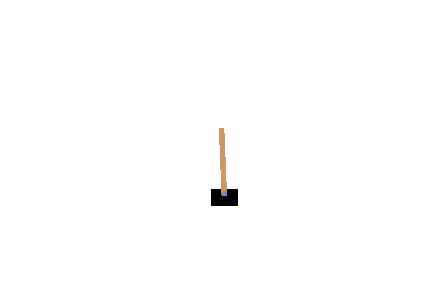
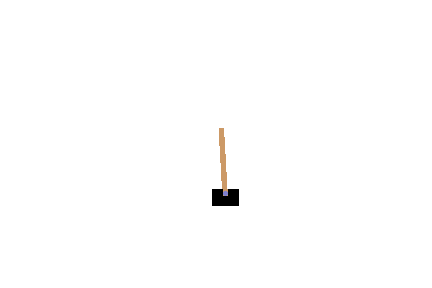
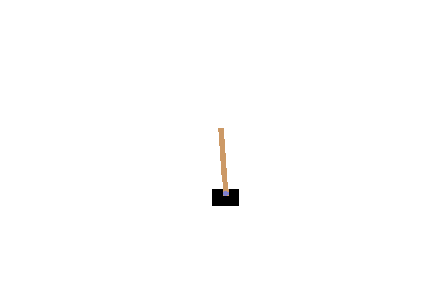
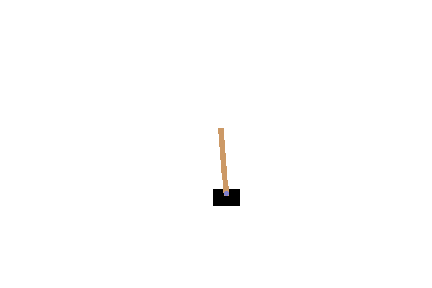
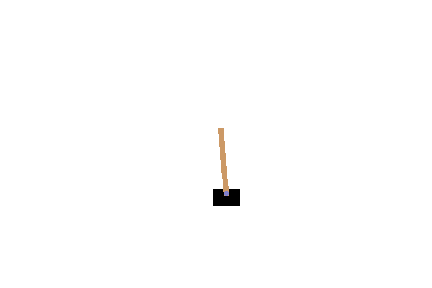
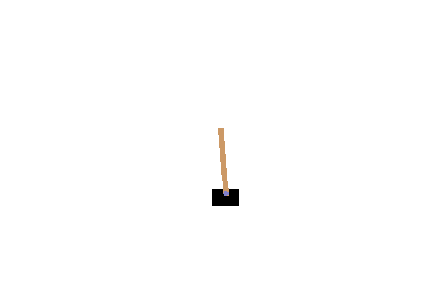
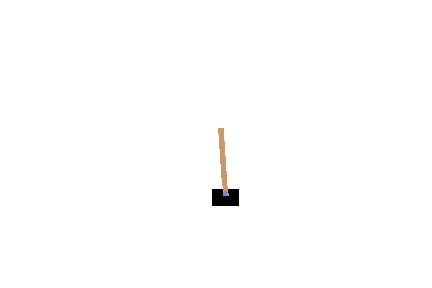
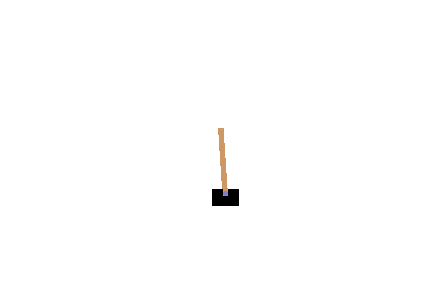
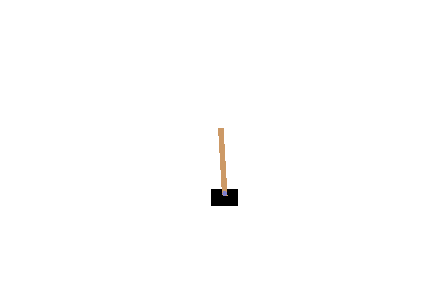
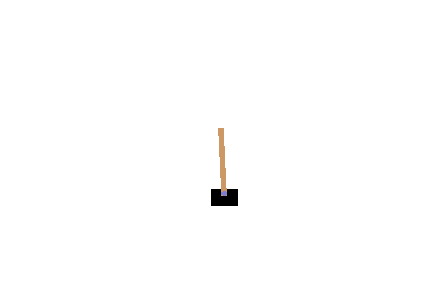
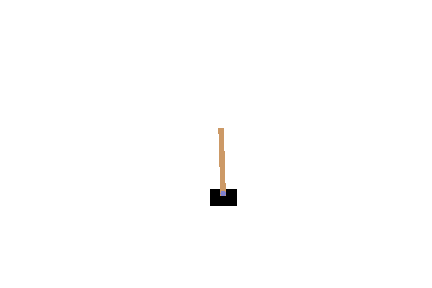
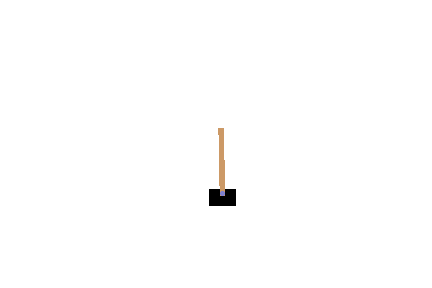
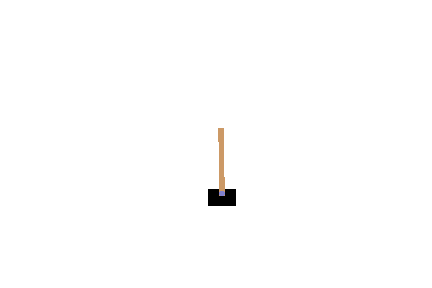
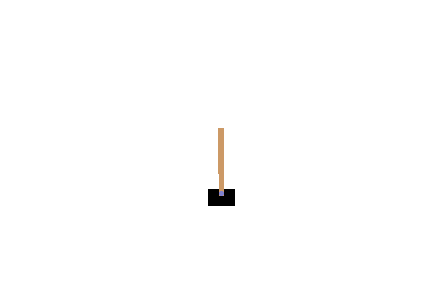
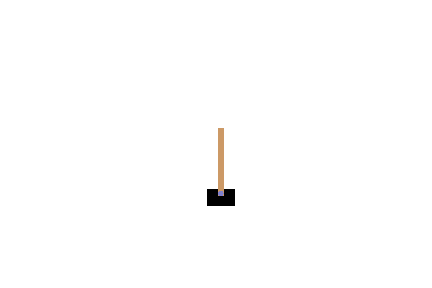
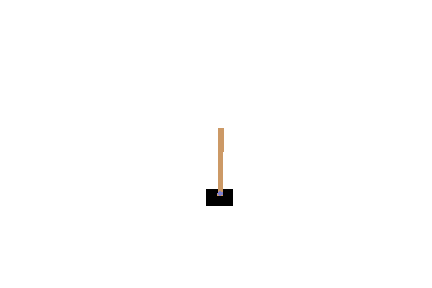
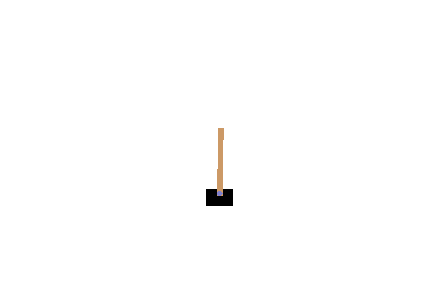
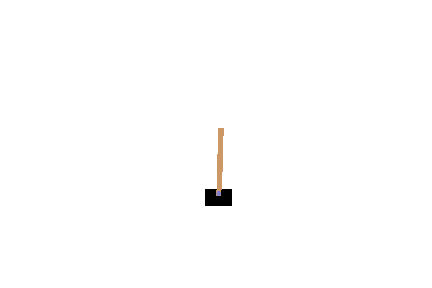
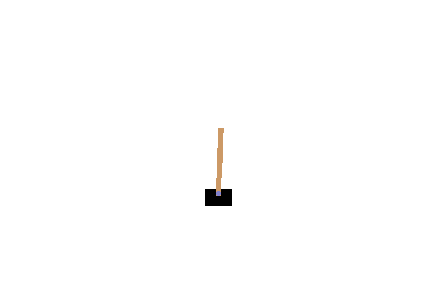
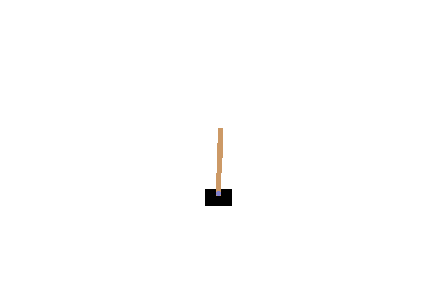
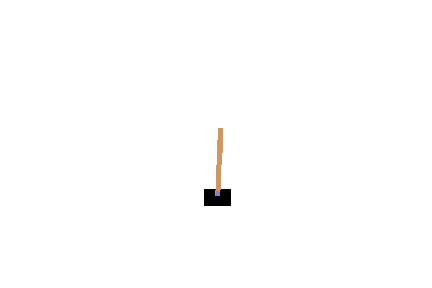
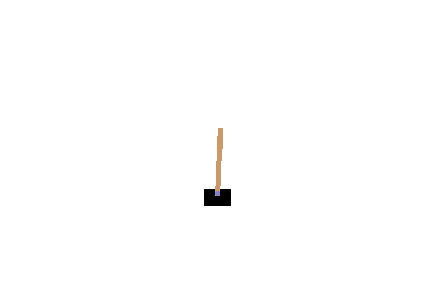
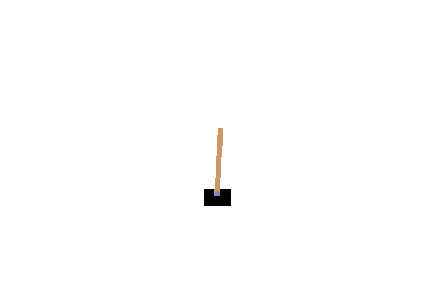
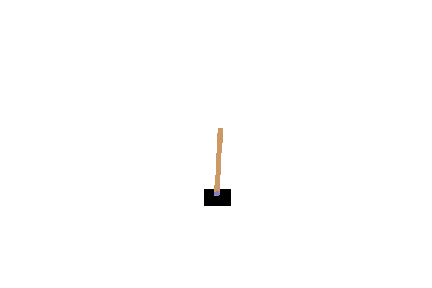
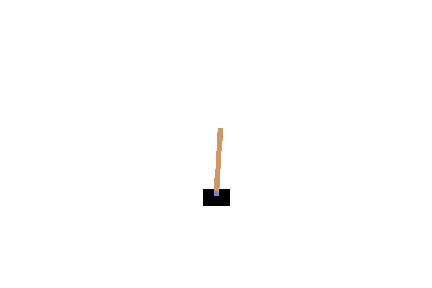
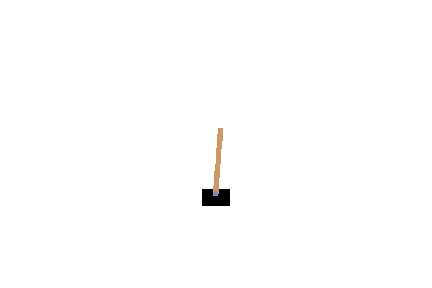
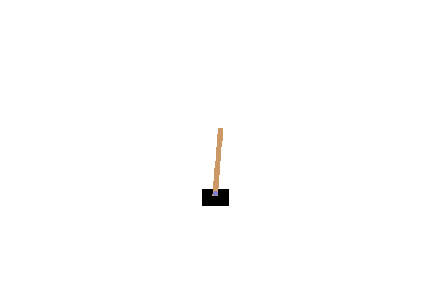
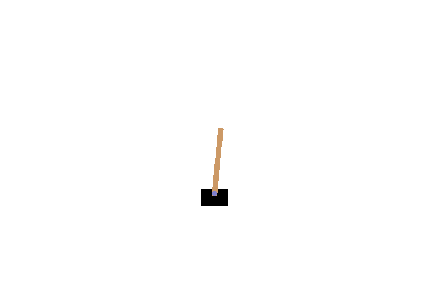
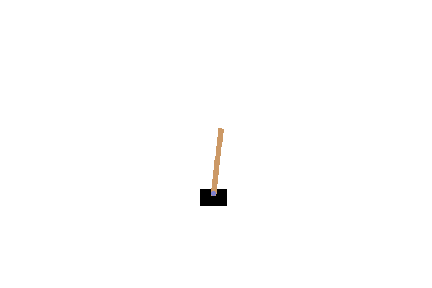
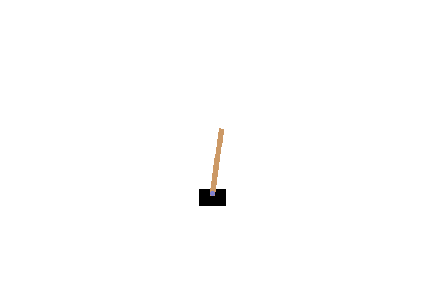
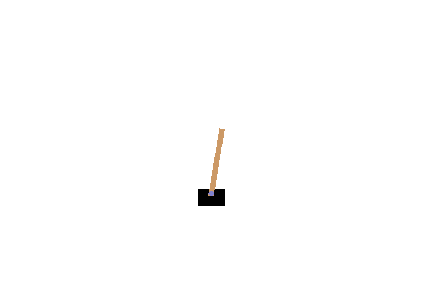
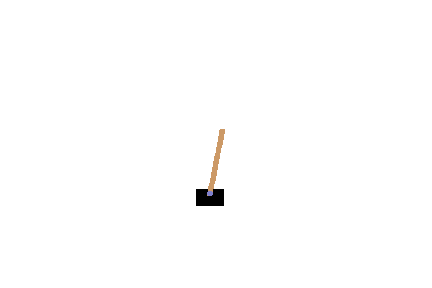
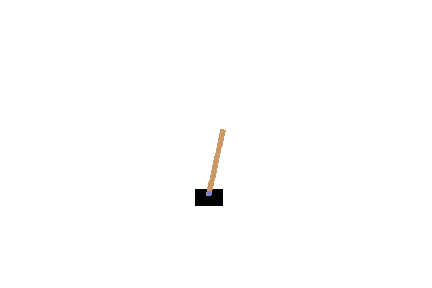

In [2]:
agent = DQNCartPoleSolver()
agent.train(1000)
agent.displaySingleEpisode()